In [1]:
from scipy import stats
import pandas as pd
import numpy as np

# Read data set
hd_df = pd.read_csv('heart disease.csv')

## Show Dataset attributes and descriptive stats

In [2]:
# Dataset makeup
print("Dataset")
print(hd_df.head())
print("\nDataset information")
print(hd_df.info())

# Descriptive statistics
print("\nDescriptive Statistics")
print(hd_df.describe())

# Duplicates?
print("\nDuplicate rows:\n", hd_df[hd_df.duplicated()])

Dataset
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          -------

In [3]:
count_zeros_col = (hd_df['RestingBP'] == 0).sum()
print(f"Number of zeros in RestingBP: {count_zeros_col}")

count_zeros_col = (hd_df['Age'] == 0).sum()
print(f"Number of zeros in Age: {count_zeros_col}")

count_zeros_col = (hd_df['Cholesterol'] == 0).sum()
print(f"Number of zeros in Cholesterol: {count_zeros_col}")

Number of zeros in RestingBP: 1
Number of zeros in Age: 0
Number of zeros in Cholesterol: 172


## Drop rows where certain column values are 0.
### Rows will be fewer than 1% of data set.

In [4]:
# Drop records with RestingBP = 0
hd_df = hd_df[hd_df['RestingBP'] != 0]

# Re-index after dropped rows
hd_df = hd_df.reset_index(drop=True)

## Show unique values of categorical columns for creating dummy variables

In [5]:
# Determine unique values in categorical columns
cat_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']

unique_values = {col: hd_df[col].unique().tolist() for col in cat_columns}

for col, values in unique_values.items():
    print(f"Unique values in '{col}': {values}")

Unique values in 'Sex': ['M', 'F']
Unique values in 'ChestPainType': ['ATA', 'NAP', 'ASY', 'TA']
Unique values in 'RestingECG': ['Normal', 'ST', 'LVH']
Unique values in 'ExerciseAngina': ['N', 'Y']
Unique values in 'ST_Slope': ['Up', 'Flat', 'Down']
Unique values in 'FastingBS': [0, 1]


## Transform variables from single character to more descriptive names

In [6]:
# Change M/F to Male/Female so dummy variable column header makes more sense
hd_df['Sex'] = hd_df['Sex'].replace({
    'M': 'Male',
    'F': 'Female'
})

# Change Y/N values to Yes/No so dummy variable column header makes more sense
hd_df['ExerciseAngina'] = hd_df['ExerciseAngina'].replace({
    'N': 'No',
    'Y': 'Yes'
})

# Change 0/1 values to Yes/No so dummy variable column header makes more sense
hd_df['FastingBS'] = hd_df['FastingBS'].replace({
    0: 'No',
    1: 'Yes'
})


## Create binary variables and mapping ordinal values

In [7]:
# Include dummy variables for columns containing binary values
dummy_df1 = pd.get_dummies(hd_df['Sex'], prefix='Sex', drop_first=True, dtype=int)
dummy_df2 = pd.get_dummies(hd_df['ExerciseAngina'], prefix='Ex_Ang', drop_first=True, dtype=int)
dummy_df3 = pd.get_dummies(hd_df['FastingBS'], prefix='FastingBS', drop_first=True, dtype=int)
dummy_df4 = pd.get_dummies(hd_df['ChestPainType'], prefix='ChestPainType', drop_first=True, dtype=int)
dummy_df5 = pd.get_dummies(hd_df['RestingECG'], prefix='RestingECG', drop_first=True, dtype=int)
dummy_df6 = pd.get_dummies(hd_df['ST_Slope'], prefix='ST_Slope', drop_first=True, dtype=int)

hd_df = pd.concat([hd_df, dummy_df1, dummy_df2, dummy_df3, dummy_df4, dummy_df5, dummy_df6], axis=1)


## Create category version of target variable for EDA purposes
#### (Keep binary variable for model learning)

In [8]:
hd_df['HeartDisease_Category'] = hd_df['HeartDisease'].map({0: 'No', 1: 'Yes'})

## Impute values of cholesterol using PMM

In [9]:
# Initialize MICEData with the dataset
from statsmodels.imputation.mice import MICEData
import statsmodels.formula.api as smf

cols_to_include = ['Cholesterol', 'Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'Sex_Male', 'Ex_Ang_Yes',
                   'FastingBS_Yes', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
                   'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up']

# Zeros are treated as true values rather than values to be imputed.
# Replacing the zeros with null will allow the impute algorithm to work as intended
hd_df['Cholesterol'] = hd_df['Cholesterol'].replace(0, np.nan)

mice_data_df = hd_df[cols_to_include].copy() # Algorithm requires numeric columns for predictors

mice_data = MICEData(mice_data_df)

# Specify imputation for Cholesterol using numeric columns
predictor_cols = 'Age + RestingBP + MaxHR + Oldpeak + Sex_Male + Ex_Ang_Yes + FastingBS_Yes + ChestPainType_NAP + ChestPainType_TA + RestingECG_Normal + RestingECG_ST + ST_Slope_Flat + ST_Slope_Up'
mice_data.set_imputer('Cholesterol', formula=predictor_cols)

mice_data.update_all(n_iter=10)  # Run MICE for 10 iterations

# Get the imputed dataset
imputed_data = mice_data.data

In [10]:
# Extract only the imputed column Cholesterol and make new column to check imputing results
hd_df['Imputed_Cholesterol'] = imputed_data['Cholesterol']

# Print number of NaN values in original column
print("\nNumber of rows where Cholestoral = NaN: ", hd_df['Cholesterol'].isna().sum())

# Print number of zero values in imputed column
print("\nNumber of rows where Imputed Cholestoral = 0: ",(hd_df['Imputed_Cholesterol'] == 0).sum())

# Print number of NaN values in imputed column
print("\nNumber of rows where Imputed Cholestoral = NaN: ",hd_df['Imputed_Cholesterol'].isna().sum())

# Side-by-side comparison
print("\n",hd_df.loc[hd_df['Imputed_Cholesterol'] != hd_df['Cholesterol'], ['Cholesterol', 'Imputed_Cholesterol']])



Number of rows where Cholestoral = NaN:  171

Number of rows where Imputed Cholestoral = 0:  0

Number of rows where Imputed Cholestoral = NaN:  0

      Cholesterol  Imputed_Cholesterol
293          NaN                218.0
294          NaN                335.0
295          NaN                236.0
296          NaN                258.0
297          NaN                246.0
..           ...                  ...
513          NaN                287.0
514          NaN                217.0
517          NaN                264.0
534          NaN                203.0
535          NaN                233.0

[171 rows x 2 columns]


## Display results after preparation

In [11]:
# Check results
print("Dataset")
print(hd_df.head())
print("\nDataset information")
print(hd_df.info())
# Descriptive statistics
print("\nDescriptive Statistics")
print(hd_df.describe())

Dataset
   Age     Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  \
0   40    Male           ATA        140        289.0        No     Normal   
1   49  Female           NAP        160        180.0        No     Normal   
2   37    Male           ATA        130        283.0        No         ST   
3   48  Female           ASY        138        214.0        No     Normal   
4   54    Male           NAP        150        195.0        No     Normal   

   MaxHR ExerciseAngina  Oldpeak  ... FastingBS_Yes  ChestPainType_ATA  \
0    172             No      0.0  ...             0                  1   
1    156             No      1.0  ...             0                  0   
2     98             No      0.0  ...             0                  1   
3    108            Yes      1.5  ...             0                  0   
4    122             No      0.0  ...             0                  0   

   ChestPainType_NAP  ChestPainType_TA  RestingECG_Normal  RestingECG_ST  \
0       

## Determine distributions

In [12]:
print("Counts of categorical variables")
print("\n",hd_df['HeartDisease_Category'].value_counts())
print("\n",hd_df['Sex'].value_counts())
print("\n",hd_df['ChestPainType'].value_counts())
print("\n",hd_df['FastingBS'].value_counts())
print("\n",hd_df['RestingECG'].value_counts())
print("\n",hd_df['ST_Slope'].value_counts())

Counts of categorical variables

 HeartDisease_Category
Yes    507
No     410
Name: count, dtype: int64

 Sex
Male      724
Female    193
Name: count, dtype: int64

 ChestPainType
ASY    496
NAP    202
ATA    173
TA      46
Name: count, dtype: int64

 FastingBS
No     703
Yes    214
Name: count, dtype: int64

 RestingECG
Normal    551
LVH       188
ST        178
Name: count, dtype: int64

 ST_Slope
Flat    459
Up      395
Down     63
Name: count, dtype: int64


## Perform different analyses

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs

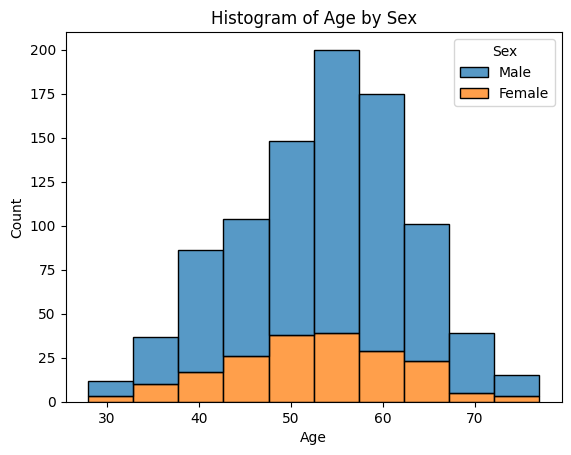

In [14]:
# Plot histogram of Age by Sex
sns.histplot(data=hd_df, x='Age', hue='Sex', multiple='stack', bins=10)
plt.title('Histogram of Age by Sex')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs

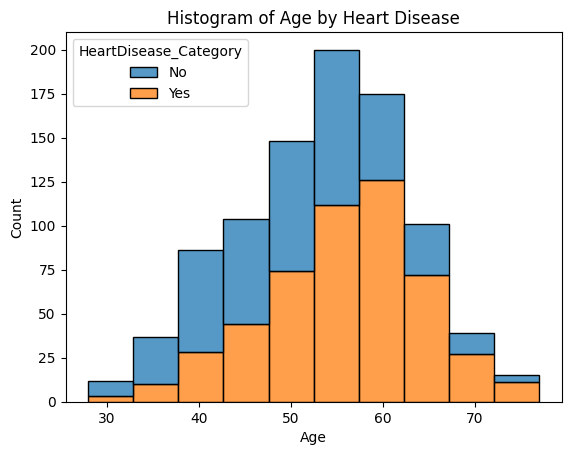

In [15]:
# Plot histogram of Age by Heart Disease
sns.histplot(data=hd_df, x='Age', hue='HeartDisease_Category', multiple='stack', bins=10)
plt.title('Histogram of Age by Heart Disease')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs

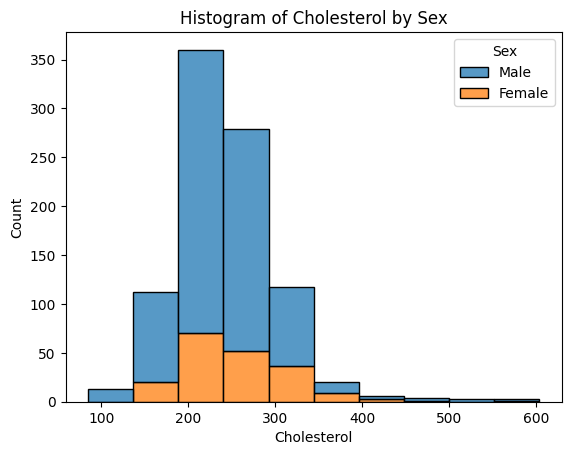

In [16]:
# Plot histogram of Cholesterol by Sex
sns.histplot(data=hd_df, x='Imputed_Cholesterol', hue='Sex', multiple='stack', bins=10)
plt.title('Histogram of Cholesterol by Sex')
plt.xlabel('Cholesterol')
plt.ylabel('Count')
plt.show()

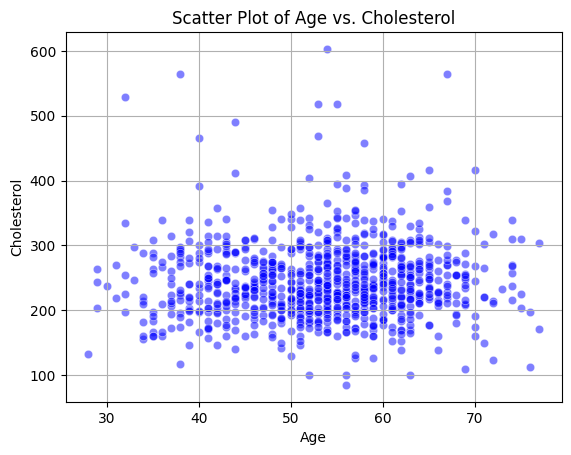

In [17]:
# Plot Scatter Plot of Cholesterol and Age
sns.scatterplot(data=hd_df, x='Age', y='Imputed_Cholesterol', color='blue', alpha=0.5)
plt.title('Scatter Plot of Age vs. Cholesterol')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.grid(True)
plt.show()

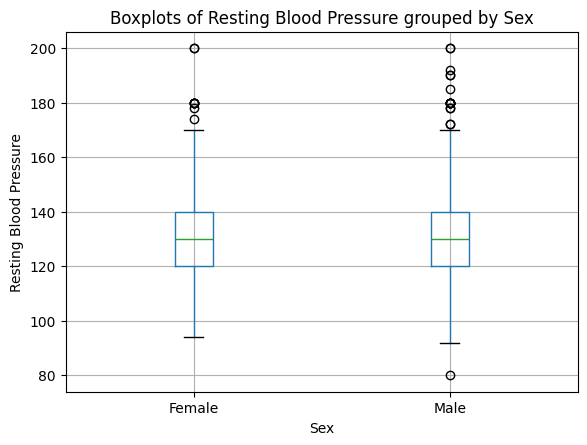

In [18]:
# Plot Box Plot of Resting BP by Sex
hd_df.boxplot(column='RestingBP', by='Sex')
plt.title('Boxplots of Resting Blood Pressure grouped by Sex')
plt.suptitle('')  # Remove default title
plt.xlabel('Sex')
plt.ylabel('Resting Blood Pressure')
plt.show()

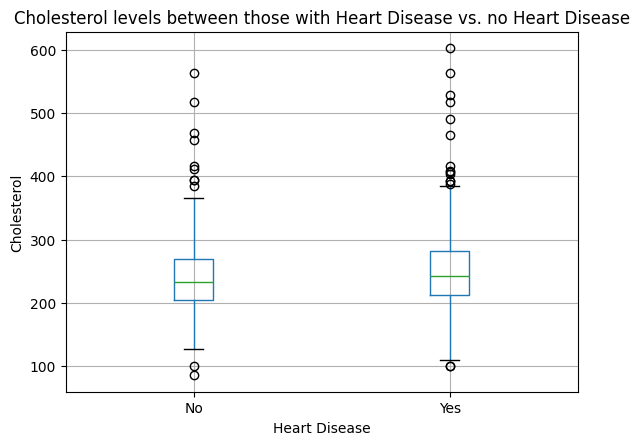

In [19]:
# Plot Box Plot of cholesterol and heart disease
hd_df.boxplot(column='Imputed_Cholesterol', by='HeartDisease_Category')
plt.title('Cholesterol levels between those with Heart Disease vs. no Heart Disease')
plt.suptitle('')  # Remove default title
plt.xlabel('Heart Disease')
plt.ylabel('Cholesterol')
plt.show()

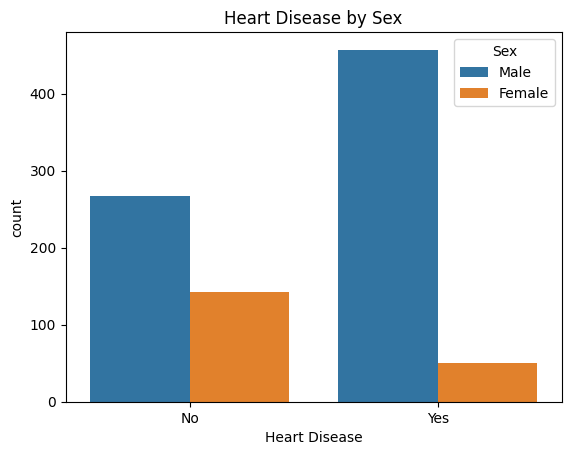

In [20]:
# Grouped Bar Chart of Heart Disease by Sex
sns.countplot(data=hd_df, x='HeartDisease_Category', hue='Sex')
plt.title("Heart Disease by Sex")
plt.xlabel('Heart Disease')
plt.show()

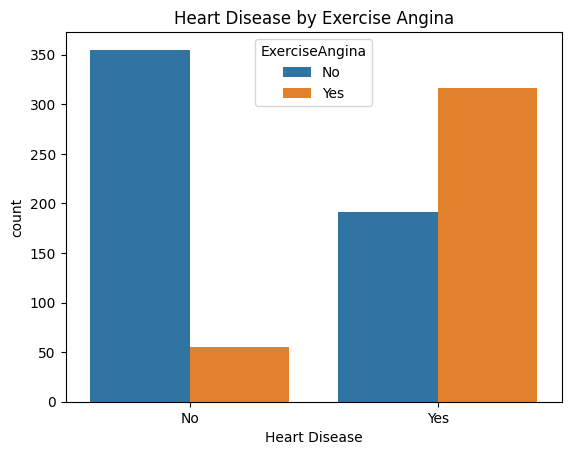

In [21]:
# Grouped Bar Chart of Heart Disease by Exercise Angina
sns.countplot(data=hd_df, x='HeartDisease_Category', hue='ExerciseAngina')
plt.title("Heart Disease by Exercise Angina")
plt.xlabel('Heart Disease')
plt.show()

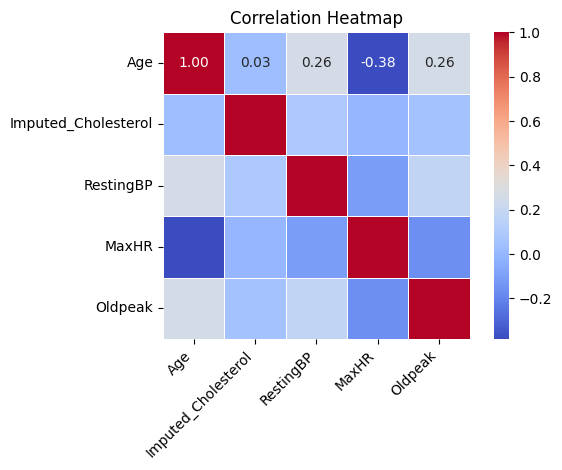

In [22]:
# Compute correlation matrix for only specific columns 
columns_to_correlate = ['Age', 'Imputed_Cholesterol', 'RestingBP', 'MaxHR', 'Oldpeak']
corr_matrix = hd_df[columns_to_correlate].corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45, ha='right') # 45-degree angle for x-axis labels
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [23]:
# Helps me remember what the variables are rather than scrolling to the top :-)
print(hd_df.columns)

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'Sex_Male', 'Ex_Ang_Yes', 'FastingBS_Yes',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up',
       'HeartDisease_Category', 'Imputed_Cholesterol'],
      dtype='object')


## Fit logistic regression model using all features

In [47]:
# Define features to use in the model
cols_to_use = ['Age', 'RestingBP', 'Imputed_Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_Male', 'Ex_Ang_Yes',
               'FastingBS_Yes', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 
               'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up']

# Extract target variable (heart disease status)
y = hd_df['HeartDisease']

# Use feature variables
X = hd_df[cols_to_use]

# Split data into training (80%) and testing (20%) sets with fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=85)

# Train logistic regression model with increased max_iter to ensure convergence
# Code kept crashing with fewer iterations, so set as 10,000
lr_model = LogisticRegression(max_iter=10000).fit(X_train, y_train)

## Determine probabilities and predictions, report results

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# Import necessary evaluation metrics from scikit-learn

# Predict probabilities and classes
y_prob = lr_model.predict_proba(X_test)[:, 1]  # Get probability estimates for positive class (class 1)
y_pred = lr_model.predict(X_test)  # Get class predictions (0 or 1)

# Evaluate the model using multiple metrics
report = classification_report(y_test, y_pred)  # Generate detailed classification metrics
conf_matrix = confusion_matrix(y_test, y_pred)  # Create confusion matrix (TN, FP, FN, TP)
accuracy = accuracy_score(y_test, y_pred)  # Correct predictions / total predictions
auc = roc_auc_score(y_test, y_prob)  # Calculate model's ability to discriminate

# Display evaluation results
print("Confusion Matrix:\n", conf_matrix)
print("\nAccuracy:", accuracy)
print("\nAUC:", auc) 
print("\nClassification Report\n",report)

Confusion Matrix:
 [[65  9]
 [13 97]]

Accuracy: 0.8804347826086957

AUC: 0.9443488943488944

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.88      0.86        74
           1       0.92      0.88      0.90       110

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



## Determine statistically significant features

In [51]:
import statsmodels.api as sm

# Add a constant term to the training and test features
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Initialize a logistic regression model using statsmodels
sm_model = sm.Logit(y_train, X_train_sm)

# Fit the model using Newton's method with a high iteration limit to ensure convergence
sm_result = sm_model.fit(method ='newton', max_iter=10000)

# Display results
print(sm_result.summary())

# Create a DataFrame of p-values to test for significance
p_values = pd.DataFrame(sm_result.pvalues, columns=['p_value'], index=X_train_sm.columns)

# Flag variables as significant if p-value within 95% confidence level
p_values['significant'] = p_values['p_value'] < 0.05
print("\nP-values and Significance:\n", p_values)

# Display statistically significant variables
significant_vars = p_values[p_values['significant']].index.tolist()
print("\nStatistically Significant Variables (p < 0.05):\n", significant_vars)

Optimization terminated successfully.
         Current function value: 0.341066
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  733
Model:                          Logit   Df Residuals:                      717
Method:                           MLE   Df Model:                           15
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.5055
Time:                        03:01:23   Log-Likelihood:                -250.00
converged:                       True   LL-Null:                       -505.54
Covariance Type:            nonrobust   LLR p-value:                 2.572e-99
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.8799      1.617     -1.162      0.245      -5.050       1.290
Ag

/home/aea16718-ceee-4ca6-88c5-1b88908a4f6e/.local/lib/python3.11/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


## Determine optimal threshold

In [53]:
from sklearn.metrics import roc_curve

# Calculate false positive rate, true positive rate, and thresholds
# y_test contains the actual labels, y_prob contains the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Determining the maximum difference between true positive rate and false positive rate
optimal_idx = np.argmax(tpr - fpr)

# Get the threshold value corresponding to the optimal index
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 0.339229276265643


## Display new results after reducing threshold

In [54]:
# Get predicted values for those that are above the threshold
y_pred_reduced = (y_prob >= optimal_threshold).astype(int)

# Obtain new results using the reduced threshold predictions
conf_matrix_reduced = confusion_matrix(y_test, y_pred_reduced)
report_reduced = classification_report(y_test, y_pred_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

print("\nConfusion Matrix (Reduced Threshold):\n", conf_matrix_reduced)
print("\nAccuracy:", accuracy_reduced)
print("\nClassification Report (Reduced Threshold):\n", report_reduced)


Confusion Matrix (Reduced Threshold):
 [[ 62  12]
 [  6 104]]

Accuracy: 0.9021739130434783

Classification Report (Reduced Threshold):
               precision    recall  f1-score   support

           0       0.91      0.84      0.87        74
           1       0.90      0.95      0.92       110

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



## Fit reduced model

In [66]:
# Remove some features. After several variations, 
# I kept Age and MaxHR in the model as the model performed best with them included 
new_cols_to_include =  ['Age', 'MaxHR', 'Oldpeak', 'Sex_Male', 'Ex_Ang_Yes', 'FastingBS_Yes', 'ChestPainType_ATA',
                        'ChestPainType_NAP', 'ChestPainType_TA', 'ST_Slope_Flat']

# Set up and train model on reduced set of features
new_X = hd_df[new_cols_to_include]
new_y = hd_df['HeartDisease']

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=85)

new_lr_model = LogisticRegression(max_iter=10000).fit(new_X_train, new_y_train)


## Display new results on reduced model, default threshold

In [55]:
# Obtain the probabilities and predictions based on the reduced model
new_y_prob = new_lr_model.predict_proba(new_X_test)[:, 1]
new_y_pred = new_lr_model.predict(new_X_test)

# Evaluate the reduced model
report = classification_report(new_y_test, new_y_pred)
conf_matrix = confusion_matrix(new_y_test, new_y_pred)
accuracy = accuracy_score(new_y_test, new_y_pred)
auc = roc_auc_score(new_y_test, new_y_prob)

# Print results
print("Confusion Matrix:\n", conf_matrix)
print("\nAccuracy:", accuracy)
print("\nAUC:", auc)
print("\nClassification Report\n",report)

Confusion Matrix:
 [[65  9]
 [13 97]]

Accuracy: 0.8804347826086957

AUC: 0.9383292383292383

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.88      0.86        74
           1       0.92      0.88      0.90       110

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



## Calculate new optimum threshold and display results on reduced model

In [56]:
# As before, calculate the optimum threshold on the reduced model predictions
fpr, tpr, thresholds = roc_curve(new_y_test, new_y_prob)
optimal_idx = np.argmax(tpr - fpr)
new_optimal_threshold = thresholds[optimal_idx]
print("New optimal Threshold:", new_optimal_threshold)

# Evaluate the reduced model based on the optimum threshold
new_y_pred_reduced = (new_y_prob >= new_optimal_threshold).astype(int)
conf_matrix_reduced = confusion_matrix(y_test, new_y_pred_reduced)
report_reduced = classification_report(y_test, new_y_pred_reduced)
accuracy_reduced = accuracy_score(y_test, new_y_pred_reduced)

# Print results
print("\nConfusion Matrix (Reduced Threshold):\n", conf_matrix_reduced)
print("\nAccuracy:", accuracy_reduced)
print("\nClassification Report (Reduced Threshold):\n", report_reduced)

New optimal Threshold: 0.22927253353483668

Confusion Matrix (Reduced Threshold):
 [[ 59  15]
 [  3 107]]

Accuracy: 0.9021739130434783

Classification Report (Reduced Threshold):
               precision    recall  f1-score   support

           0       0.95      0.80      0.87        74
           1       0.88      0.97      0.92       110

    accuracy                           0.90       184
   macro avg       0.91      0.89      0.90       184
weighted avg       0.91      0.90      0.90       184



## Create and evaluate SVM model

In [60]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# X and y will be the same as used for the full Logistic Regression model 

#Train/test split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.2, random_state=8)

#Standardize features
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

#Train the SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=11)  # use `probability=True` for AUC
svm_model.fit(X_train_svm, y_train_svm)

# Predictions
y_proba_svm = svm_model.predict_proba(X_test_svm)[:, 1]  # Probabilities for AUC
y_pred_svm = svm_model.predict(X_test_svm)

# Evaluate and print results
conf_matrix_svm = confusion_matrix(y_test_svm, y_pred_svm)
report_svm = classification_report(y_test_svm, y_pred_svm)
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
auc_score_svm = roc_auc_score(y_test_svm, y_proba_svm)

# Print results
print("Confusion Matrix:\n", conf_matrix_svm)
print("\nAccuracy: ", accuracy_svm)
print("\nAUC Score: ", auc_score_svm)
print("\nClassification Report:\n", report_svm)

Confusion Matrix:
 [[71 15]
 [11 87]]

Accuracy:  0.8586956521739131

AUC Score:  0.9005695301376364

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85        86
           1       0.85      0.89      0.87        98

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



## Fit a reduced SVM model and evaluate

In [67]:
#The split will use "new_X" and "new_y" as was done for the reduced Logistic Regression model

#Train/test split
X_train_svm_reduced, X_test_svm_reduced, y_train_svm_reduced, y_test_svm_reduced = train_test_split(new_X, new_y, test_size=0.2, random_state=22)

#Standardize features
scaler = StandardScaler()
X_train_svm_reduced = scaler.fit_transform(X_train_svm_reduced)
X_test_svm_reduced = scaler.transform(X_test_svm_reduced)

#Train the SVM model
svm_reduced_model = SVC(kernel='rbf', probability=True, random_state=2)  # use `probability=True` for AUC
svm_reduced_model.fit(X_train_svm_reduced, y_train_svm_reduced)

# Predictions
y_proba_svm_reduced = svm_reduced_model.predict_proba(X_test_svm_reduced)[:, 1]  # Probabilities for AUC
y_pred_svm_reduced = svm_reduced_model.predict(X_test_svm_reduced)

# Evaluate and print results
conf_matrix_svm_reduced = confusion_matrix(y_test_svm_reduced, y_pred_svm_reduced)
report_svm_reduced = classification_report(y_test_svm_reduced, y_pred_svm_reduced)
accuracy_svm_reduced = accuracy_score(y_test_svm_reduced, y_pred_svm_reduced)
auc_score_svm_reduced = roc_auc_score(y_test_svm_reduced, y_proba_svm_reduced)

# Print results
print("Confusion Matrix:\n", conf_matrix_svm_reduced)
print("\nAccuracy: ", accuracy_svm_reduced)
print("\nAUC Score: ", auc_score_svm_reduced)
print("\nClassification Report:\n", report_svm_reduced)

Confusion Matrix:
 [[64 14]
 [10 96]]

Accuracy:  0.8695652173913043

AUC Score:  0.9014271891630382

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84        78
           1       0.87      0.91      0.89       106

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



## Calculating and using the optimum threshold for a reduced SVM model

In [68]:
# As before, calculate the optimum threshold on the reduced model predictions
fpr, tpr, thresholds = roc_curve(y_test_svm_reduced, y_proba_svm_reduced)
optimal_idx_svm = np.argmax(tpr - fpr)
optimal_threshold_svm = thresholds[optimal_idx_svm]
print("New optimal Threshold:", optimal_threshold_svm)

# Evaluate the reduced model based on the optimum threshold
y_pred_svm_reduced = (y_proba_svm_reduced >= optimal_threshold_svm).astype(int)
conf_matrix_svm_reduced = confusion_matrix(y_test_svm_reduced, y_pred_svm_reduced)
report_svm_reduced = classification_report(y_test_svm_reduced, y_pred_svm_reduced)
accuracy_svm_reduced = accuracy_score(y_test_svm_reduced, y_pred_svm_reduced)

# Print results
print("\nConfusion Matrix (Reduced Threshold):\n", conf_matrix_svm_reduced)
print("\nAccuracy:", accuracy_svm_reduced)
print("\nClassification Report (Reduced Threshold):\n", report_svm_reduced)

New optimal Threshold: 0.3523550589761677

Confusion Matrix (Reduced Threshold):
 [[ 62  16]
 [  6 100]]

Accuracy: 0.8804347826086957

Classification Report (Reduced Threshold):
               precision    recall  f1-score   support

           0       0.91      0.79      0.85        78
           1       0.86      0.94      0.90       106

    accuracy                           0.88       184
   macro avg       0.89      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184

